# Bloch-Redfield Solver: Phonon-assisted initialization

Author: K.A. Fischer, Stanford University

This Jupyter notebook demonstrates how to use the time-dependent Bloch-Redfield master equation solver to simulate the phonon-assisted initialization of a quantum dot, using QuTiP: The Quantum Toolbox in Python. The purpose is to show how environmentally-driven dissipative interactions can be leveraged to initialize a quantum dot into its excited state. This notebook closely follows the work, <a href="https://arxiv.org/abs/1409.6014">Dissipative preparation of the exciton and biexciton in self-assembled quantum
dots on picosecond time scales</a>, Phys. Rev. B 90, 241404(R) (2014).

For more information about QuTiP see the project web page: http://qutip.org/ 

In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
from qutip import (about, fock, parallel_map, sigmam, BRSolver,
                   QobjEvo, coefficient)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Introduction

The quantum two-level system (TLS) is the simplest possible model to describe the quantum light-matter interaction between light and an artificial atom (quantum dot). While the version in the paper (both experiment and simulation) used a three-level system model, I decided to show only a TLS model here to minimize the notebook's runtime.

In the version we simulate here, the system is driven by a continuous-mode coherent state, whose dipolar interaction with the system is represented by the following Hamiltonain

$$ H =\hbar \omega_0 \sigma^\dagger \sigma + \frac{\hbar\Omega(t)}{2}\left( \sigma\textrm{e}^{-i\omega_dt} + \sigma^\dagger \textrm{e}^{i\omega_dt}\right),$$

where $\omega_0$ is the system's transition frequency, $\sigma$ is the system's atomic lowering operator, $\omega_d$ is the coherent state's center frequency, and $\Omega(t)$ is the coherent state's driving strength.

The time-dependence can be removed to simplify the simulation by a rotating frame transformation. Then,

$$ H_r =\hbar \left(\omega_0-\omega_d\right) \sigma^\dagger \sigma + \frac{\hbar\Omega(t)}{2}\left( \sigma+ \sigma^\dagger \right).$$

Additionally, the quantum dot exists in a solid-state matrix, where environmental interactions are extremely important. In particular, the coupling between acoustic phonons and the artifical atom leads to important dephasing effects. While the collapse operators of the quantum-optical master equation can be used to phenomenologically model these effects, they do not necessarily provide any direct connection to the underlying physics of the system-environmental interaction.

Instead, the Bloch-Redfield master equation allows for a direct connection between the quantum dynamics and the underlying physical interaction mechanism. Furthermore, the interaction strengths can be derived from first principles and can include complex power-dependences, such as those that exist in the quantum-dot-phonon interaction. Though we note that there are important non-Markovian effects which are now being investigated, e.g. in the paper <a href="https://journals.aps.org/prb/abstract/10.1103/PhysRevB.95.201305">Limits to coherent scattering and photon coalescence from solid-state quantum emitters</a>, Phys. Rev. B 95, 201305(R) (2017).

### Problem parameters

Note, we use units where $\hbar=1$.

In [2]:
# pulse area
n_Pi = 13

# driving strengths
Om_list = np.linspace(0.001, n_Pi, 80)
# laser offsets in meV
wd_list_e = np.array([-1, 0, 1])
# laser offsets in angular frequency
wd_list = wd_list_e * 1.5
# simulation time with tmax ~ 2x FWHM
tlist = np.linspace(0, 50, 40)

# normalized Gaussian pulse shape, ~10ps long in energy
t0 = 17 / (2 * np.sqrt(2 * np.log(2)))
pulse_shape = "0.0867 * exp(-(t - 24) ** 2 / (2 * {0} ** 2))".format(t0)

### Setup the operators, Hamiltonian, and initial state

In [3]:
# initial state
psi0 = fock(2, 1)  # ground state

# system's atomic lowering operator
sm = sigmam()

# Hamiltonian components
H_S = -sm.dag() * sm  # self-energy, varies with drive frequency
H_I = sm + sm.dag()

# we ignore spontaneous emission since the pulse is much faster than
# the decay time
c_ops = []

Below, we define the terms specific to the Bloch-Redfield solver's system-environmental coupling. The quantum dot couples to acoustic phonons in its solid-state environment through a dispersive electron-phonon interaction of the form

$$ H_\textrm{phonon}=\hbar J(\omega)\sigma^\dagger \sigma,$$

where $J(\omega)$ is the spectral density of the coupling.

In [4]:
# operator that couples the quantum dot to acoustic phonons
a_op = sm.dag() * sm

# This spectrum is a displaced gaussian multiplied by w^3, which
# models coupling to LA phonons. The electron and hole
# interactions contribute constructively.


# fitting parameters ae/ah
ah = 1.9e-9  # m
ae = 3.5e-9  # m
# GaAs material parameters
De = 7
Dh = -3.5
v = 5110  # m/s
rho_m = 5370  # kg/m^3
# Other Constants
hbar = 1.05457173e-34  # Js
T = 4.2  # Kelvin, temperature

# constants for temperature dependence
t1 = 0.6582119
t2 = 0.086173

# General J factor
J = (
    "(1.6 * 1e-13 * w**3) / (4 * pi**2 * rho_m * hbar * v**5) * "
    + "(De * exp(-(w * 1e12 * ae * 0.5 / v)**2) - "
    + "Dh * exp(-(w * 1e12 * ah * 0.5 / v)**2))**2"
)

# Term for positive frequencies
JT_p = (
    J
    + "* (1 + exp(-w*t1/(T*t2)) / \
          (1-exp(-w*t1/(T*t2))))"
)

# Term for negative frequencies
JT_m = (
    "-1.0* "
    + J
    + "* exp(w*t1/(T*t2)) / \
            (1-exp(w*t1/(T*t2)))"
)


# define spectra with variable names
spectra_cb = "(w > 0) * " + JT_p + "+ (w < 0) * " + JT_m

# add a check for min size of w to avoid numerical problems
spectra_cb = "0 if (w > -1e-4 and w < 1e-4) else " + spectra_cb

# define string with numerical values expect for w
constants = ["ah", "ae", "De", "Dh", "v", "rho_m", "hbar", "T", "t1", "t2"]
spectra_cb_numerical = spectra_cb
for c in constants:
    # replace constants with numerical value
    spectra_cb_numerical = spectra_cb_numerical.replace(c, str(eval(c)))

## Visualize the dot-phonon interaction spectrum

$J(\omega)$ has two components that give rise to its shape: a rising component due to the increasing acoustic phonon density of states and a roll-off that occurs due to the physical size of the quantum dot.

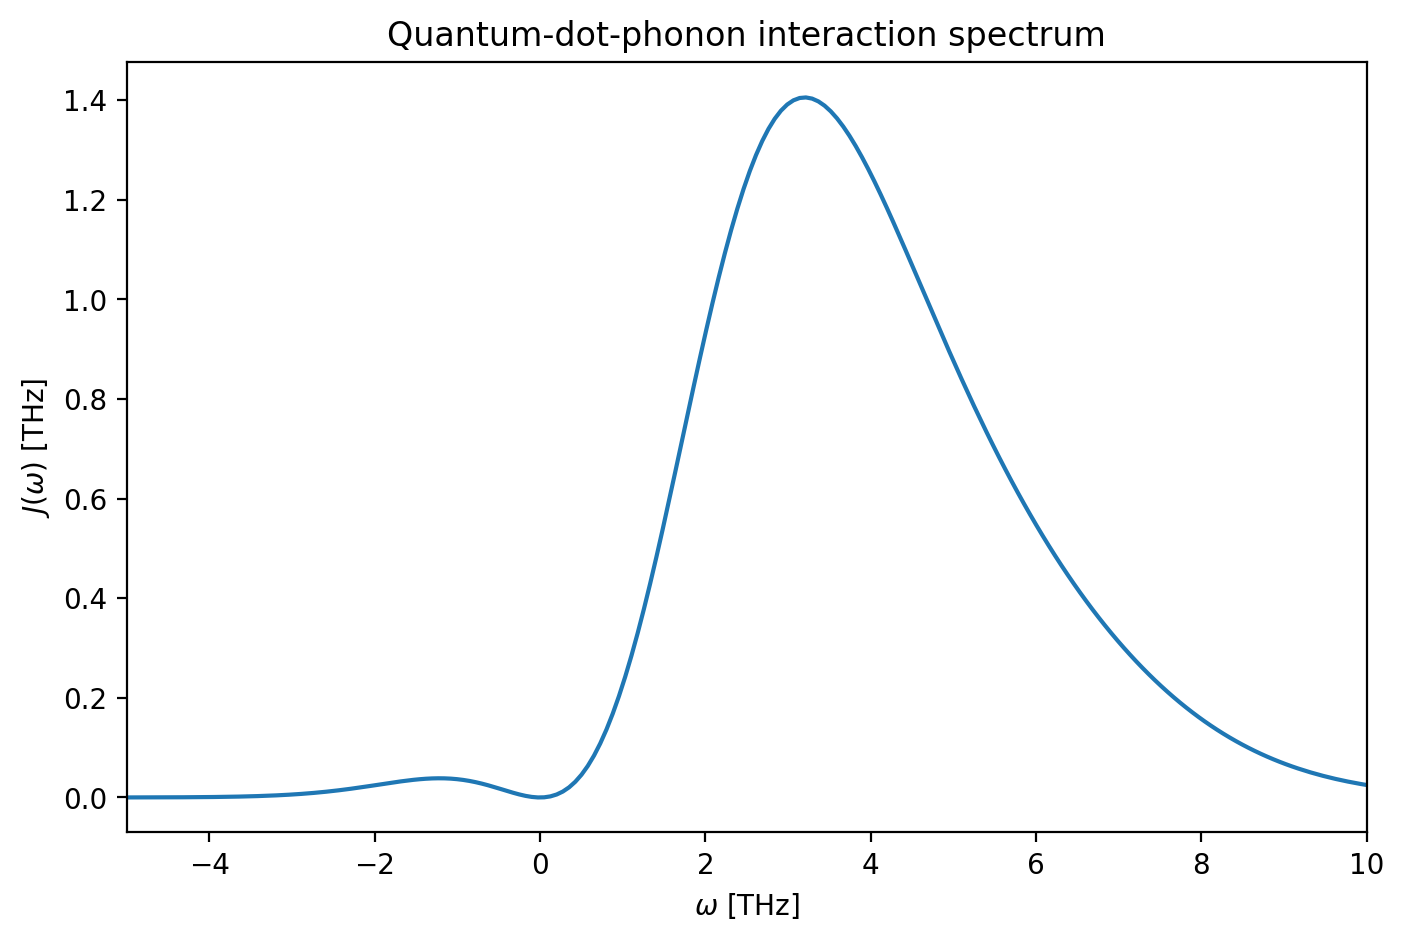

In [5]:
# frequency list
spec_list = np.linspace(-5, 10, 200)

# define shortcuts to evaluate string
pi = np.pi
exp = np.exp

# plot the spectrum J(w)
plt.figure(figsize=(8, 5))
plt.plot(spec_list, [eval(spectra_cb.replace("w", str(_))) for _ in spec_list])
plt.xlim(-5, 10)
plt.xlabel("$\\omega$ [THz]")
plt.ylabel("$J(\\omega)$ [THz]")
plt.title("Quantum-dot-phonon interaction spectrum");

## Calculate the pulse-system interaction dynamics

The Bloch-Redfield master equation solver takes the Hamiltonian time-dependence in list-string format. We calculate the final population at the end of the interaction of the pulse with the system, which represents the population initialized into the excited state.

In [6]:
# we will calculate the dot population expectation value
e_ops = [sm.dag() * sm]


# initialize BRSolver
H = QobjEvo([[H_S, 'wd'], [H_I, 'Om * ' + pulse_shape]],
            args={'wd': 0.0, 'Om': 0.0})

spectrum = coefficient(spectra_cb_numerical, args={'w': 0})
solver = BRSolver(H, [[a_op, spectrum]])


# define callback for parallelization
def brme_step(args):
    # extract coefficients for the Hamiltonian
    args = {'wd': args[0], 'Om': args[1]}

    # run the solver
    res = solver.run(psi0, tlist, e_ops=e_ops, args=args)

    # return population after the pulse interaction
    return res.expect[0][-1]


# use QuTiP's builtin parallelized for loop: parallel_map
results = parallel_map(brme_step, list(itertools.product(wd_list, Om_list)))

# unwrap the results into a 2d array
inv_mat_X = np.array(results).reshape((len(wd_list), len(Om_list)))

/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip/core/coefficient.py:423: UserWarning: `cython`, `setuptools` and `filelock` are required for compilation of string coefficents. Falling back on `eval`.
  warnings.warn(


### Visualize the quantum dot's initialization fidelity

Below, consider the trace of excited state occupation for increasing pulse area at a detuning of $\omega_d-\omega_L=0$. Here, the oscillations represent the standard Rabi oscillations of a driven two-level system, damped for increasing pulse area by a Markovian-like dephasing. This damping could be represented with a power-dependent collapse operator in the normal quantum-optical master equation. However, for nonzero pulse detunings, the results are quite nontrivial and difficult to model with a collapse operator. Herein lies the power of the Bloch-Redfield approach: it captures the dephasing in a more natural basis, the dressed atom basis, from first principles.

In this basis, the dispersive phonon-induced dephasing drives a population difference between the dressed states. This amounts to driving the system towards a dissipative quasi-steady state that initializes the population into the excited state with almost unity fidelity. The initialization effect is very insensitive to precise pulse area or laser detuning, as discussed in our paper, and hence is a powerfully robust way to pump a quantum dot into its excited state. Below is an example trace showing this dissipative initialization for a +1meV laser detuning. The high fidelity of the initialization relies on a low temperature bath that prefers phonon emission over absorption. As a complement, for a laser detuning of -1meV, the excited state is barely populated.

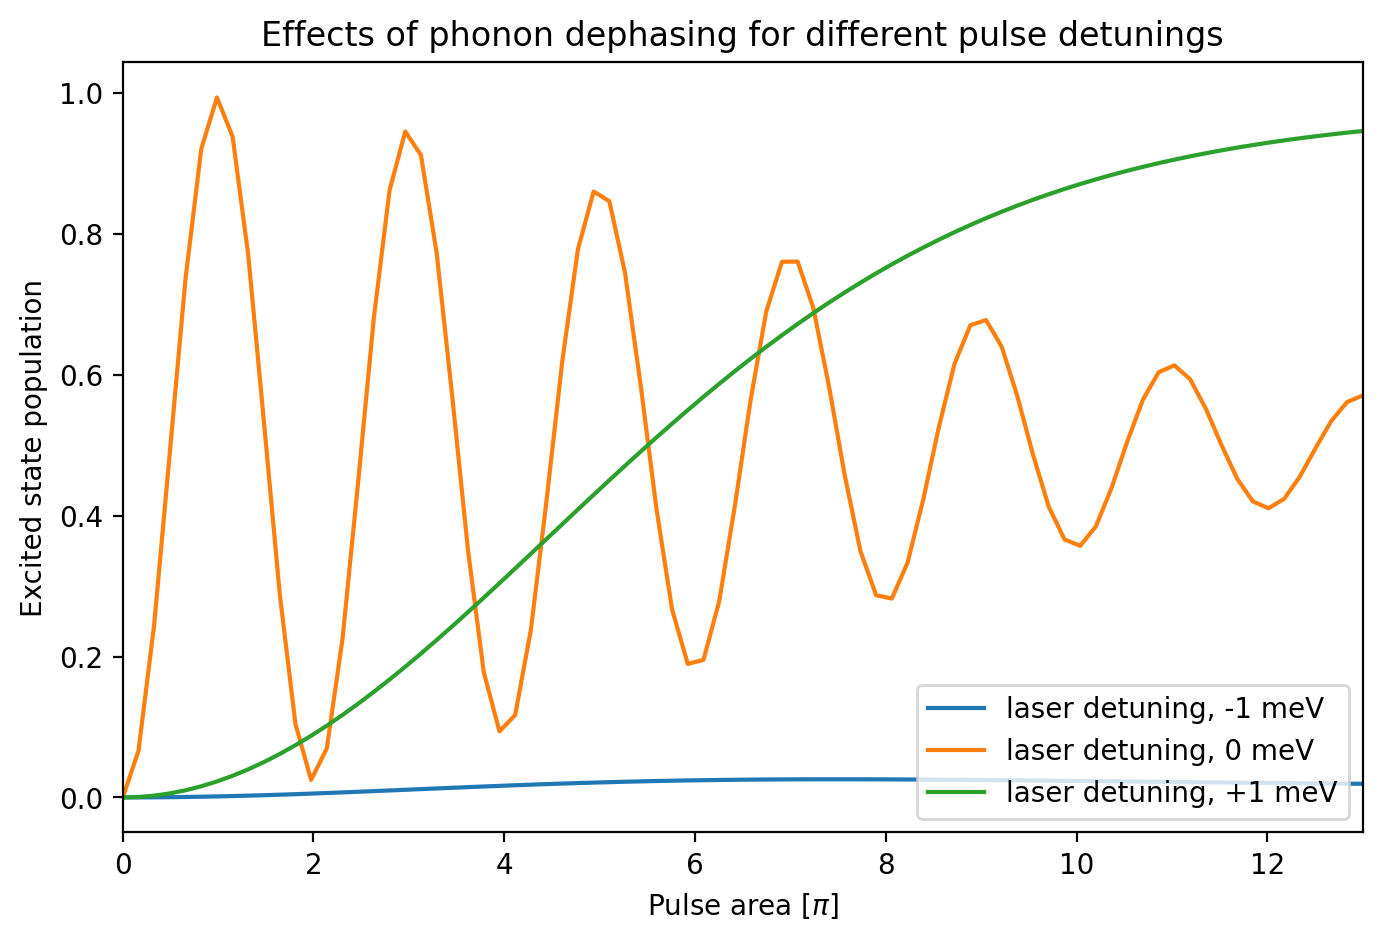

In [7]:
plt.figure(figsize=(8, 5))

plt.plot(Om_list, inv_mat_X[0])
plt.plot(Om_list, inv_mat_X[1])
plt.plot(Om_list, inv_mat_X[2])

plt.legend(["laser detuning, -1 meV", "laser detuning, 0 meV",
            "laser detuning, +1 meV"], loc=4)

plt.xlim(0, 13)
plt.xlabel("Pulse area [$\\pi$]")
plt.ylabel("Excited state population")
plt.title("Effects of phonon dephasing for different pulse detunings");

## Versions

In [8]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

qutip-jax: 0.1.1.dev6
qutip-qip: 0.5.0.dev0+81a92b9

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


### Testing

In [9]:
# monotone increasing of population expectation for +1meV detune
assert np.all(np.diff(inv_mat_X[2]) > 0)

# assert for +1meV detuning steadystate close to excited state
assert inv_mat_X[2][-1] > 0.9
# for -1meV detuning steadystate close to ground state
assert inv_mat_X[0][-1] < 0.1